# Modeling Code for Flat_Curved interface [reservior thickness 40 m]

## 1 Import Functions


In [1]:
%reset -f

In [2]:
import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_PASS_Marine/numerical_modeling/wrk/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, interpolate
import sys
sys.path.append("../")
import plotting
from pyseis.wave_equations import elastic_isotropic
from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline


## 2 Read Data

In [4]:
### Real log data
fasc = "./NK-58_Log.prn"

logz1 = 968.0
logz2 = 2481.0

restopz = 2134.0 - 16.0
co2btmz = restopz + 40.0

deps_05  = []
deps_10  = []
deps_15  = []
deps_20  = []
deps_30  = []
vp_sw100 = []
vs_sw100 = []
ro_sw100 = []
vp_co250 = []
vs_co250 = []
ro_co250 = []

with open(fasc, 'r') as io_inp:
    header = io_inp.readline()
    
    for line in io_inp:
        buf = line.split()
        dep05, dep10, dep15, dep20, dep30, \
        bvp, bvs, bro, mvp, mvs, mro = (line.rstrip()).split()
        deps_05.append(float(dep05)-16.0)
        deps_10.append(float(dep10)-16.0)
        deps_15.append(float(dep15)-16.0)
        deps_20.append(float(dep20)-16.0)
        deps_30.append(float(dep30)-16.0)
        vp_sw100.append(float(bvp))
        vs_sw100.append(float(bvs))
        ro_sw100.append(float(bro)*1000.)
        vp_co250.append(float(mvp))
        vs_co250.append(float(mvs))
        ro_co250.append(float(mro)*1000.)

deps_05  = np.array(deps_05, dtype="float32")
deps_10  = np.array(deps_10, dtype="float32")
deps_15  = np.array(deps_15, dtype="float32")
deps_20  = np.array(deps_20, dtype="float32")
deps_30  = np.array(deps_30, dtype="float32")
vp_sw100 = np.array(vp_sw100, dtype="float32")
vs_sw100 = np.array(vs_sw100, dtype="float32")
ro_sw100 = np.array(ro_sw100, dtype="float32")
vp_co250 = np.array(vp_co250, dtype="float32")
vs_co250 = np.array(vs_co250, dtype="float32")
ro_co250 = np.array(ro_co250, dtype="float32")
        
finterpo_vp_sw100 = interpolate.interp1d(deps_10, vp_sw100, kind='cubic')
finterpo_vs_sw100 = interpolate.interp1d(deps_10, vs_sw100, kind='cubic')
finterpo_ro_sw100 = interpolate.interp1d(deps_10, ro_sw100, kind='cubic')
finterpo_vp_co250 = interpolate.interp1d(deps_10, vp_co250, kind='cubic')
finterpo_vs_co250 = interpolate.interp1d(deps_10, vs_co250, kind='cubic')
finterpo_ro_co250 = interpolate.interp1d(deps_10, ro_co250, kind='cubic')

deps_d2m = np.arange(logz1, logz2, 2.0)


logvp_sw100_d2m = finterpo_vp_sw100(deps_d2m)
logvs_sw100_d2m = finterpo_vs_sw100(deps_d2m)
logro_sw100_d2m = finterpo_ro_sw100(deps_d2m)
logvp_co250_d2m = finterpo_vp_co250(deps_d2m)
logvs_co250_d2m = finterpo_vs_co250(deps_d2m)
logro_co250_d2m = finterpo_ro_co250(deps_d2m)

# --- make Vp a little bigger (apply after interpolation) ---
scale_vp  = 1.25   # +5%
offset_vp = 0.0    # +0 m/s

logvp_sw100_d2m = logvp_sw100_d2m * scale_vp + offset_vp
logvp_co250_d2m = logvp_co250_d2m * scale_vp + offset_vp


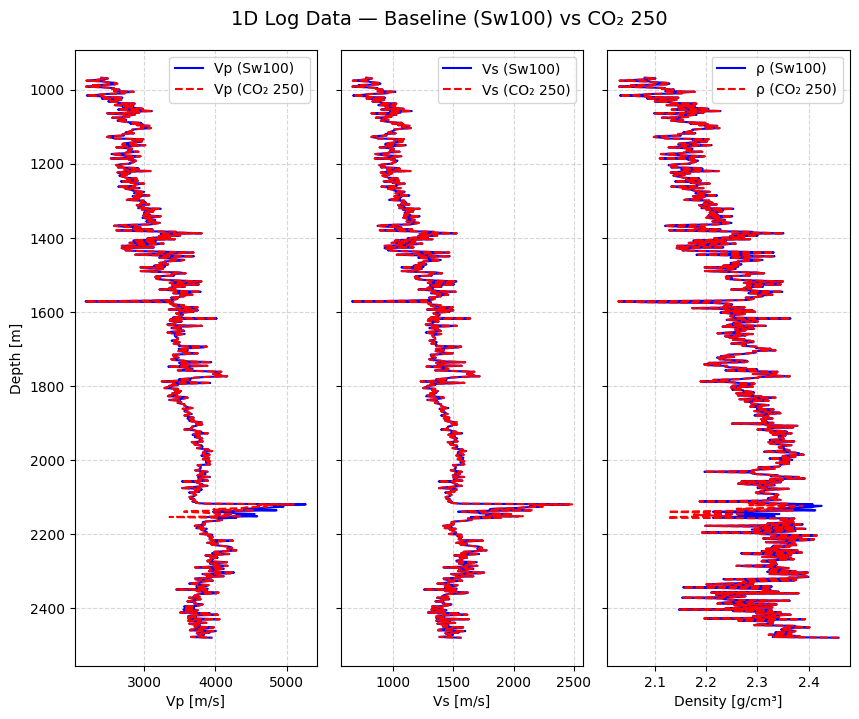

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define depth range ---
zmin, zmax = logz1, logz2

# --- Create figure ---
fig, axes = plt.subplots(1, 3, figsize=(10, 8), sharey=True)
plt.suptitle("1D Log Data — Baseline (Sw100) vs CO₂ 250", fontsize=14, y=0.93)

# --- P-wave velocity ---
axes[0].plot(logvp_sw100_d2m, deps_d2m, 'b-', label='Vp (Sw100)')
axes[0].plot(logvp_co250_d2m, deps_d2m, 'r--', label='Vp (CO₂ 250)')
axes[0].set_xlabel("Vp [m/s]")
axes[0].set_ylabel("Depth [m]")
axes[0].invert_yaxis()
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# --- S-wave velocity ---
axes[1].plot(logvs_sw100_d2m, deps_d2m, 'b-', label='Vs (Sw100)')
axes[1].plot(logvs_co250_d2m, deps_d2m, 'r--', label='Vs (CO₂ 250)')
axes[1].set_xlabel("Vs [m/s]")
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

# --- Density ---
axes[2].plot(logro_sw100_d2m/1000.0, deps_d2m, 'b-', label='ρ (Sw100)')
axes[2].plot(logro_co250_d2m/1000.0, deps_d2m, 'r--', label='ρ (CO₂ 250)')
axes[2].set_xlabel("Density [g/cm³]")
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend()

# --- Final layout ---
plt.subplots_adjust(wspace=0.1)
plt.show()


## 3 Constract curved model

In [6]:
### Construct 1D model
dir_model = "./model/"
dir_seis  = "./seis/"
ox=0.0; oz=0.0
ex=2000.0; ez=2501
dx=2.0; dz=2.0
nx=len(np.arange(ox,ex,dx)); nz=len(np.arange(oz,ez,dz))
print(nx,nz)
padx, padz = 200, 200
model_sampling = (dx, dz)

model_origins  = (ox, oz)
model_padding  = (padx, padz)


vp2d_base_true = np.zeros((nx,nz))
vs2d_base_true = np.zeros((nx,nz))
ro2d_base_true = np.zeros((nx,nz))
vp2d_moni_true = np.zeros((nx,nz))
vs2d_moni_true = np.zeros((nx,nz))
ro2d_moni_true = np.zeros((nx,nz))


1000 1251


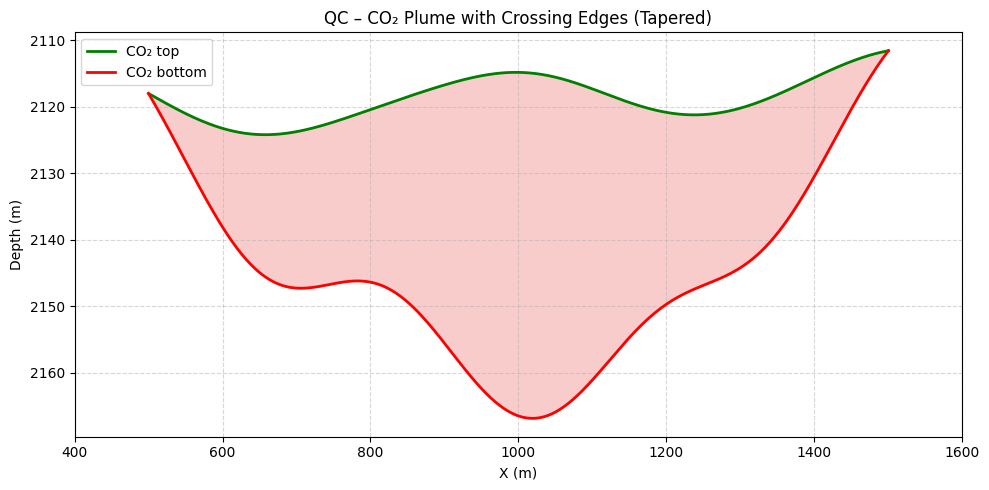

In [7]:
# --- REBUILD CO2 PLUME USING THE TAPERED (CROSSING-EDGES) SHAPE ---

xpos = np.arange(ox, ex, dx)
mask_injection = (xpos >= 500.0) & (xpos <= 1500.0)

# top undulation + bumps (inside window only)
amp_top, lam_top = 6.0, 600.0
top_var = np.ones_like(xpos, dtype=float) * restopz
top_var[mask_injection] += amp_top * np.sin(2*np.pi * (xpos[mask_injection]-500.0)/lam_top)

def gauss(x, x0, a, w):
    return a * np.exp(-0.5*((x-x0)/w)**2)

top_var[mask_injection] += gauss(xpos[mask_injection],  900.0,  4.0, 100.0)
top_var[mask_injection] += gauss(xpos[mask_injection], 1300.0, -3.0, 150.0)

# thickness with taper -> 0 at both edges (500,1500)
base_thk, amp_thk, lam_thk = 40.0, 8.0, 400.0
thk_var = np.zeros_like(xpos, dtype=float)
thk_core = base_thk + amp_thk * np.sin(2*np.pi * (xpos[mask_injection]-500.0)/lam_thk)
thk_core += gauss(xpos[mask_injection], 1100.0, 6.0, 100.0)
thk_core = np.clip(thk_core, 20.0, 70.0)

taper = np.sin(np.pi * (xpos[mask_injection] - 500.0) / 1000.0)  # 0 at edges, 1 center
taper = np.clip(taper, 0.0, 1.0)
thk_var[mask_injection] = thk_core * taper

# compute top/bottom (NaN outside window so we skip overwrite there)
co2topz_d2m = np.full_like(xpos, np.nan, dtype=float)
co2btmz_d2m = np.full_like(xpos, np.nan, dtype=float)
co2topz_d2m[mask_injection] = np.clip(top_var[mask_injection], deps_d2m[0], deps_d2m[-1]-2.0)
co2btmz_d2m[mask_injection] = np.clip((top_var[mask_injection] + thk_var[mask_injection]),
                                      deps_d2m[0]+2.0, deps_d2m[-1])

# --- RECREATE 2D MONITORING LOGS FROM BASE, THEN OVERWRITE ONLY INSIDE THE TAPERED PLUME ---
nlogz = len(logvp_co250_d2m)
logvp2d_co250_d2m = np.tile(logvp_sw100_d2m, (nx, 1))
logvs2d_co250_d2m = np.tile(logvs_sw100_d2m, (nx, 1))
logro2d_co250_d2m = np.tile(logro_sw100_d2m, (nx, 1))

for ix in range(nx):
    if not mask_injection[ix]:
        continue
    ztop = co2topz_d2m[ix]; zbtm = co2btmz_d2m[ix]
    if np.isnan(ztop) or np.isnan(zbtm) or (zbtm <= ztop):
        continue
    itop = int(np.searchsorted(deps_d2m, ztop, side='left'))
    ibtm = int(np.searchsorted(deps_d2m, zbtm, side='left'))
    ibtm = max(itop+1, min(ibtm, nlogz))
    logvp2d_co250_d2m[ix, itop:ibtm] = logvp_co250_d2m[itop:ibtm]
    logvs2d_co250_d2m[ix, itop:ibtm] = logvs_co250_d2m[itop:ibtm]
    logro2d_co250_d2m[ix, itop:ibtm] = logro_co250_d2m[itop:ibtm]
    
    
    # ---- QC Plot ----
plt.figure(figsize=(10,5))
plt.plot(xpos, co2topz_d2m, 'g-', lw=2, label='CO₂ top')
plt.plot(xpos, co2btmz_d2m, 'r-', lw=2, label='CO₂ bottom')
plt.fill_between(xpos, co2topz_d2m, co2btmz_d2m, where=~np.isnan(co2topz_d2m),
                 color='lightcoral', alpha=0.4)
plt.xlim(400, 1600)
plt.gca().invert_yaxis()
plt.xlabel('X (m)')
plt.ylabel('Depth (m)')
plt.title('QC – CO₂ Plume with Crossing Edges (Tapered)')
plt.legend()
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 4 insert the flat layer

In [8]:
# --- Force-visible 100 m water layer + seabed contrast + gradient (robust) ---

# define final depth grid before using it
ndeps_d2m = np.arange(0, ez, dz)

z_water   = 100.0
vp_water  = 1500.0
vs_water  = 1.0
rho_water = 1025.0

vp_seafloor = 1800.0
vp_logz1    = 2500.0
grad_vp     = (vp_logz1 - vp_seafloor) / max(1e-6, (logz1 - z_water))

# masks/gradient on the log grid (deps_d2m)
mask_water_dep = deps_d2m < z_water
mask_grad_dep  = (deps_d2m >= z_water) & (deps_d2m <= logz1)
vp_grad_dep    = vp_seafloor + (deps_d2m - z_water) * grad_vp

for ix in range(nx):
    # copy columns on deps_d2m
    vp_b  = logvp_sw100_d2m.copy()
    vs_b  = logvs_sw100_d2m.copy()
    ro_b  = logro_sw100_d2m.copy()

    vp_m  = logvp2d_co250_d2m[ix, :].copy()
    vs_m  = logvs2d_co250_d2m[ix, :].copy()
    ro_m  = logro2d_co250_d2m[ix, :].copy()

    # apply water on deps_d2m
    vp_b[mask_water_dep] = vp_water
    vs_b[mask_water_dep] = vs_water
    ro_b[mask_water_dep] = rho_water
    vp_m[mask_water_dep] = vp_water
    vs_m[mask_water_dep] = vs_water
    ro_m[mask_water_dep] = rho_water

    # apply gradient on deps_d2m
    vp_b[mask_grad_dep] = vp_grad_dep[mask_grad_dep]
    vp_m[mask_grad_dep] = vp_grad_dep[mask_grad_dep]

    # anchors and interpolate -> ndeps_d2m
    nlogdeps = np.append(np.insert(deps_d2m, 0, 0.0), ez)
    f = lambda y: interpolate.interp1d(nlogdeps,
                                       np.append(np.insert(y, 0, y[0]), y[-1]),
                                       kind='linear',
                                       bounds_error=False,
                                       fill_value=(y[0], y[-1]))(ndeps_d2m)

    nvp_b  = f(vp_b);  nvs_b  = f(vs_b);  nro_b  = f(ro_b)
    nvp_m  = f(vp_m);  nvs_m  = f(vs_m);  nro_m  = f(ro_m)

    # --- enforce water + gradient again on the final grid to guarantee effect ---
    mask_water_nd = ndeps_d2m < z_water
    mask_grad_nd  = (ndeps_d2m >= z_water) & (ndeps_d2m <= logz1)
    vp_grad_nd    = vp_seafloor + (ndeps_d2m - z_water) * grad_vp

    nvp_b[mask_water_nd] = vp_water
    nvs_b[mask_water_nd] = vs_water
    nro_b[mask_water_nd] = rho_water
    nvp_m[mask_water_nd] = vp_water
    nvs_m[mask_water_nd] = vs_water
    nro_m[mask_water_nd] = rho_water

    nvp_b[mask_grad_nd] = vp_grad_nd[mask_grad_nd]
    nvp_m[mask_grad_nd] = vp_grad_nd[mask_grad_nd]

    # assign
    vp2d_base_true[ix, :] = nvp_b
    vs2d_base_true[ix, :] = nvs_b
    ro2d_base_true[ix, :] = nro_b
    vp2d_moni_true[ix, :] = nvp_m
    vs2d_moni_true[ix, :] = nvs_m
    ro2d_moni_true[ix, :] = nro_m


## 6 Define Source-Receiver Geometry

In [9]:
### Define Source (3) and Receiver (212) 

# Receiver spacing and seafloor depth
drec = 10.0
recx1 = 500.0   # start position (x = 100 m)
recx2 = 1500.0  # end position (x = 2220 m)
recz = np.ones(int((recx2 - recx1) / drec)) * 100.0  # constant depth of 100 m

# Receiver x-coordinates along the seafloor
recx = np.arange(recx1, recx2, drec)

# Combine receivers into [x, z]
recs = np.column_stack((recx, recz))

# Manually specify source positions
srcx = np.array([450.0, 900.0, 1750.0])  # chosen x positions (m)
srcz = np.array([10.0, 10.0, 10.0])       # all sources at 10 m depth

# Combine sources into [x, z]
srcs = np.column_stack((srcx, srcz))




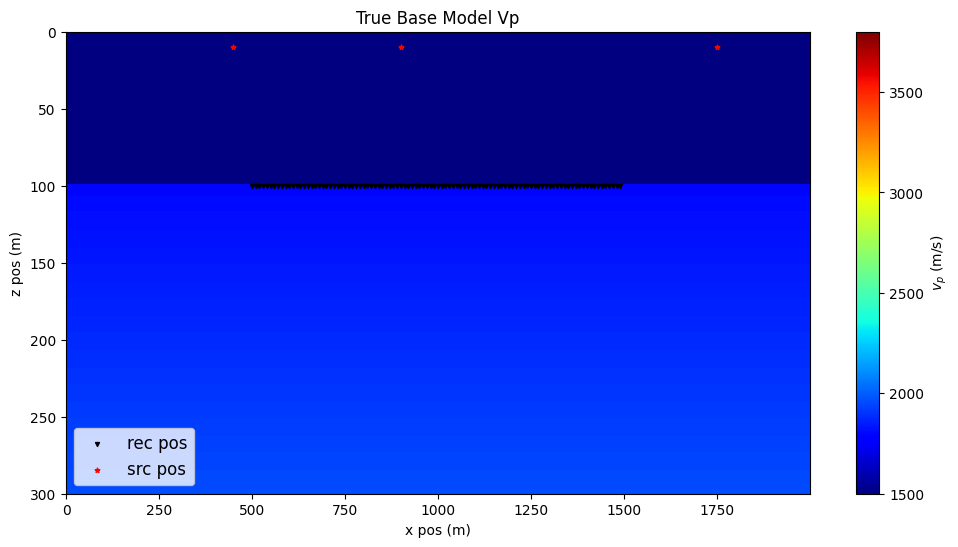

In [10]:
plotting.plot_model(vp2d_base_true,
                    title="True Base Model Vp",
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='jet',
                    cbar_label='$v_p$ (m/s)',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[1500,3800],
                    ylims= [300,0])


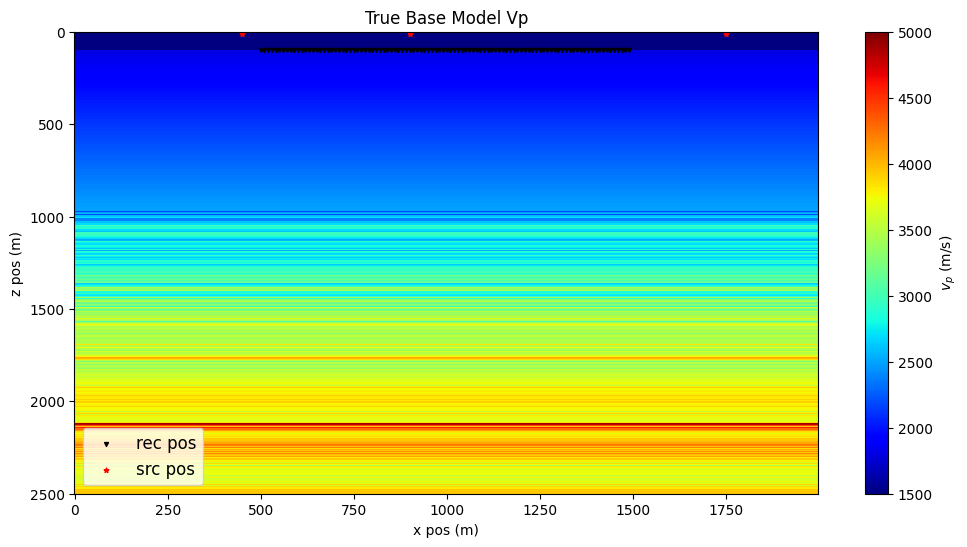

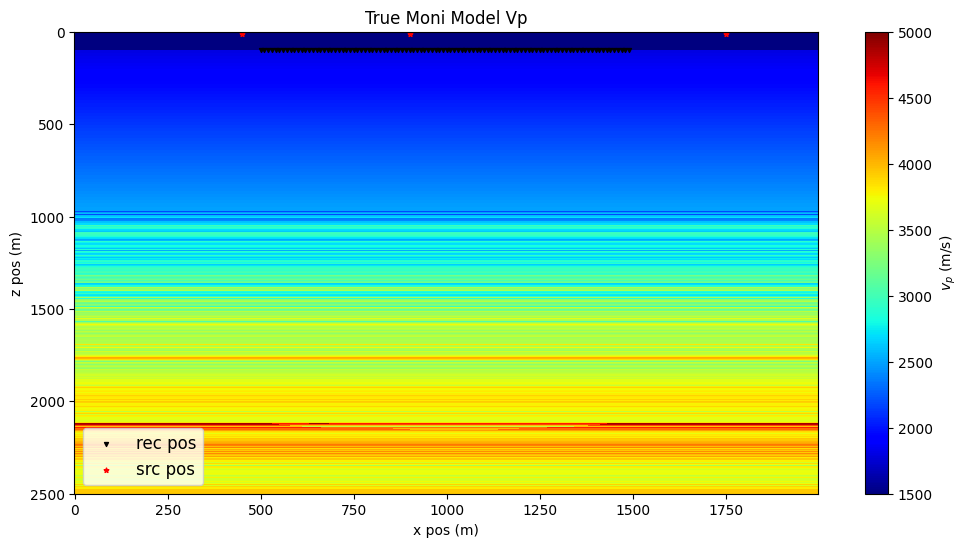

In [11]:
plotting.plot_model(vp2d_base_true,
                    title="True Base Model Vp",
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='jet',
                    cbar_label='$v_p$ (m/s)',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[1500,5000])


plotting.plot_model(vp2d_moni_true,
                    title="True Moni Model Vp",
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='jet',
                    cbar_label='$v_p$ (m/s)',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[1500,5000])

In [12]:
# ### Define Init Model 
vp2d_base_init = ndimage.gaussian_filter(vp2d_base_true, (1, 8), mode='nearest')
vs2d_base_init = ndimage.gaussian_filter(vs2d_base_true, (1, 8), mode='nearest')
ro2d_base_init = ndimage.gaussian_filter(ro2d_base_true, (1, 8), mode='nearest') 
vp2d_moni_init = ndimage.gaussian_filter(vp2d_moni_true, (1, 8), mode='nearest')
vs2d_moni_init = ndimage.gaussian_filter(vs2d_moni_true, (1, 8), mode='nearest')
ro2d_moni_init = ndimage.gaussian_filter(ro2d_moni_true, (1, 8), mode='nearest')

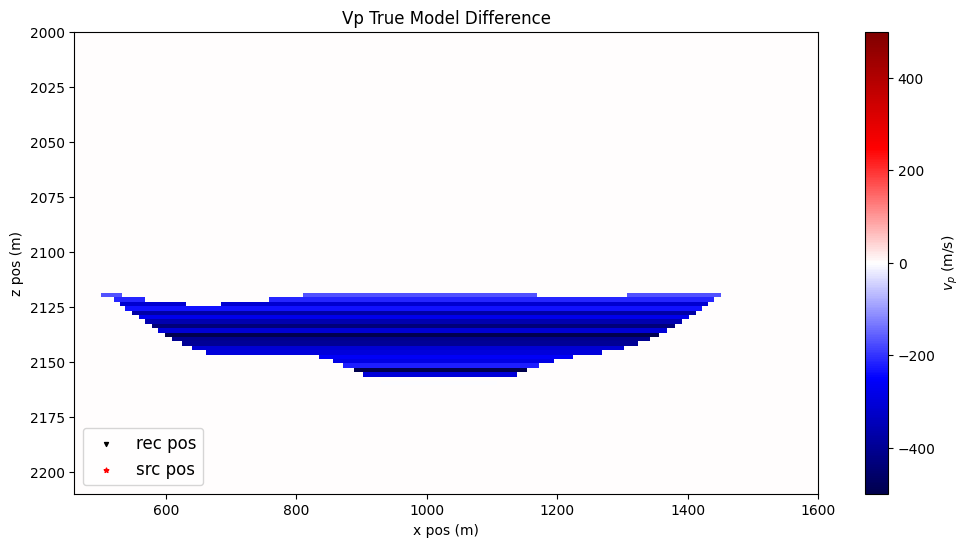

In [13]:
plotting.plot_model(vp2d_moni_true-vp2d_base_true,
                    title="Vp True Model Difference",
                    cbar=True,
                    sampling=model_sampling,
                    origins=model_origins,
                    cmap='seismic',
                    cbar_label='$v_p$ (m/s)',
                    src_locations=srcs,
                    rec_locations=recs,
                    figsize=(12,6),
                    vlims=[-500,500],
                    xlims=[460,1600],
                    ylims=[2210,2000]
                   )


## 8 Solve the velocity model

In [14]:
# ### Vp Model
np.array(vp2d_base_true,   dtype="float32").tofile(dir_model+"res_FC05_vp2m_base_true_Gradient.bin")
np.array(vp2d_base_init,   dtype="float32").tofile(dir_model+"res_FC05_vp2m_base_init_Gradient.bin")
np.array(vp2d_moni_true,   dtype="float32").tofile(dir_model+"res_FC05_vp2m_moni_true_Gradient.bin")
np.array(vp2d_moni_init,   dtype="float32").tofile(dir_model+"res_FC05_vp2m_moni_init_Gradient.bin")


## 9 Source Function

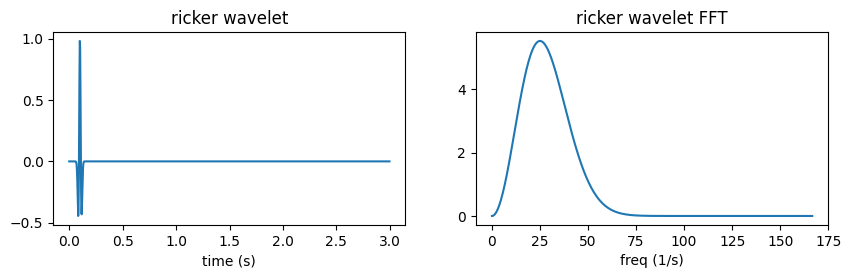

In [15]:

nt = 1000
dt = 0.003
delay = 0.1
dom_freq=25
wavelets = Acoustic2D.AcousticIsotropicRicker2D(nt, dt, dom_freq, delay).arr
plotting.plot_wavelet(wavelets,dt,title='ricker wavelet')


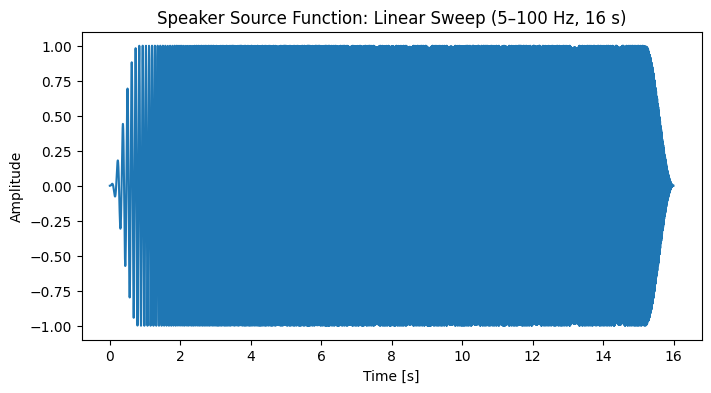

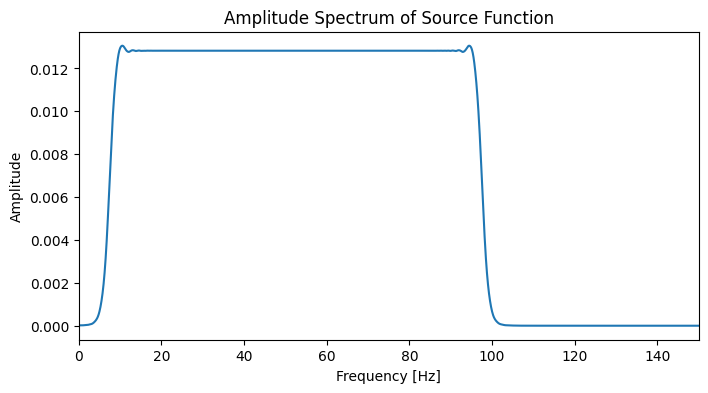

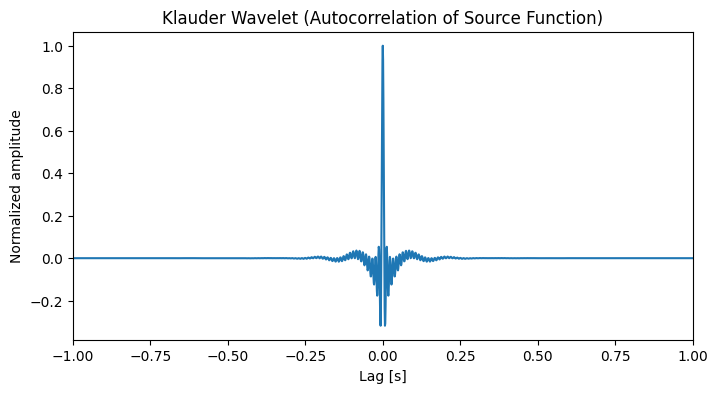

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows, correlate
from numpy.fft import rfft, rfftfreq

# --- PARAMETERS ---
fs = 1000.0          # sampling rate [Hz]
T  = 16.0            # sweep duration [s]
f0, f1 = 5.0, 100.0  # sweep band [Hz]
t = np.arange(0, T, 1/fs)

# --- LINEAR FM SWEEP (speaker source) ---
k = (f1 - f0) / T
phase = 2 * np.pi * (f0 * t + 0.5 * k * t**2)
s = np.sin(phase)

# Apply a 10% Tukey taper
s *= windows.tukey(len(s), alpha=0.1)

# --- OPTIONAL: compute amplitude spectrum and Klauder wavelet ---
X = rfft(s)
f = rfftfreq(len(s), d=1/fs)
A = np.abs(X) / len(s)

corr = correlate(s, s, mode='full')
tau = np.arange(-len(s)+1, len(s)) / fs
corr /= np.max(np.abs(corr))

# --- PLOTS ---
plt.figure(figsize=(8,4))
plt.plot(t, s)
plt.title('Speaker Source Function: Linear Sweep (5–100 Hz, 16 s)')
plt.xlabel('Time [s]'); plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(f, A)
plt.title('Amplitude Spectrum of Source Function')
plt.xlabel('Frequency [Hz]'); plt.ylabel('Amplitude'); plt.xlim(0,150)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(tau, corr)
plt.title('Klauder Wavelet (Autocorrelation of Source Function)')
plt.xlabel('Lag [s]'); plt.ylabel('Normalized amplitude'); plt.xlim(-1,1)
plt.show()


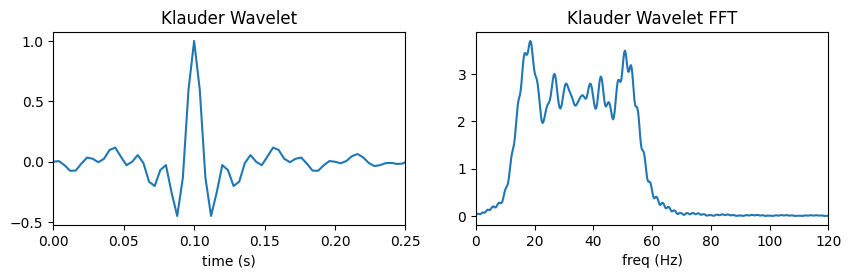

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def generate_klauder_wavelet(nt, dt, f1, f2, T, delay, taper_ratio=0.0):
    """
    Generate a Klauder wavelet by autocorrelating a linear FM (chirp) signal.
    - nt: number of samples in output wavelet
    - dt: sample interval (s)
    - f1, f2: start/end frequencies of the chirp (Hz)
    - T: chirp duration (s) used to build the wavelet
    - delay: time (s) at which the Klauder wavelet's main lobe peak will be centered in the output
    - taper_ratio: 0..1 cosine taper fraction applied to chirp ends (0 = none)
    """
    # --- build LFM chirp (source) ---
    nT = max(2, int(np.round(T / dt)))
    t_chirp = np.arange(nT) * dt
    k = (f2 - f1) / T if T > 0 else 0.0  # sweep rate (Hz/s)
    phase = 2.0 * np.pi * (f1 * t_chirp + 0.5 * k * t_chirp**2)
    s = np.cos(phase)

    # optional cosine taper to reduce sidelobes (keeps classic shape even if 0)
    if taper_ratio > 0.0:
        m = len(s)
        nedge = int(np.clip(np.floor(0.5 * taper_ratio * m), 0, m // 2))
        if nedge > 0:
            w = np.ones(m)
            # half-cosine ramps
            n = np.arange(nedge)
            w[:nedge] = 0.5 * (1 - np.cos(np.pi * (n + 1) / (nedge + 1)))
            w[-nedge:] = w[:nedge][::-1]
            s *= w

    # --- autocorrelation to get Klauder wavelet ---
    # scale by dt so energy is consistent with continuous-time integral
    ac = np.correlate(s, s, mode='full') * dt
    ac /= np.max(np.abs(ac))  # normalize peak to 1.0
    mid = len(s) - 1  # zero lag index in ac

    # --- place autocorrelation into output buffer, centered at 'delay' ---
    out = np.zeros(nt, dtype=float)
    i_delay = int(np.round(delay / dt))  # where the peak will appear
    for m in range(len(ac)):
        j = i_delay + (m - mid)
        if 0 <= j < nt:
            out[j] = ac[m]

    return out

def plot_wavelet(wavelet, d_t, title='wavelet', figsize=(10, 2.5), xlim_time=None, xlim_freq=None):
    wavelet_fft = np.fft.rfft(wavelet)
    freqs = np.fft.rfftfreq(len(wavelet), d_t)
    t = d_t * np.arange(len(wavelet))

    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].plot(t, wavelet)
    axs[0].set_xlabel('time (s)')
    axs[0].set_title(title)
    if xlim_time is not None:
        axs[0].set_xlim(xlim_time)

    axs[1].plot(freqs, np.abs(wavelet_fft))
    axs[1].set_xlabel('freq (Hz)')
    axs[1].set_title(f'{title} FFT')
    if xlim_freq is not None:
        axs[1].set_xlim(xlim_freq)

    plt.show()

# ---------------------------
# Parameters (example)
# ---------------------------
nt = 1000
dt = 0.004          # 4 ms
delay = 0.1         # peak at 0.1 s in the output
f1, f2 = 10, 60     # sweep band for the chirp (Hz)
T = 0.5             # chirp duration used to form the wavelet (s)
taper_ratio = 0.0   # 0..1, optional cosine end-taper on chirp

# Generate and plot
klauder = generate_klauder_wavelet(nt, dt, f1, f2, T, delay, taper_ratio)
plot_wavelet(klauder, dt, title='Klauder Wavelet', xlim_time=(0, 0.25), xlim_freq=(0, 120))


In [18]:
model_padding = (180,180)

In [19]:
true_base_model = np.concatenate([np.expand_dims(vp2d_base_true, axis=0),
                                  np.expand_dims(vs2d_base_true, axis=0),
                                  np.expand_dims(ro2d_base_true, axis=0)],axis=0)
true_moni_model = np.concatenate([np.expand_dims(vp2d_moni_true, axis=0),
                                    np.expand_dims(vs2d_moni_true, axis=0),
                                    np.expand_dims(ro2d_moni_true, axis=0)],axis=0)


In [20]:
print(true_base_model.shape)
print(true_moni_model.shape)

(3, 1000, 1251)
(3, 1000, 1251)


## 10 Call 2D acoustic Wave equation solver

In [21]:
# make 2d elastic wave equation solver
acoustic_2d_obs_base = acoustic_isotropic.AcousticIsotropic2D(
    model=vp2d_base_true,
    model_sampling=model_sampling,
    model_padding=model_padding,
    wavelet=klauder,
    d_t=dt,
    src_locations=srcs,
    rec_locations=recs,
    model_origins=model_origins,
    subsampling=30,
    gpus=[0])

## Start to run the modeling computation

In [22]:
%%time
data_obs_base_p = acoustic_2d_obs_base.forward(vp2d_base_true)
data_obs_moni_p = acoustic_2d_obs_base.forward(vp2d_moni_true)


CPU times: user 28.4 s, sys: 15.8 s, total: 44.2 s
Wall time: 21.3 s


## Save the Sythetic Data [P]

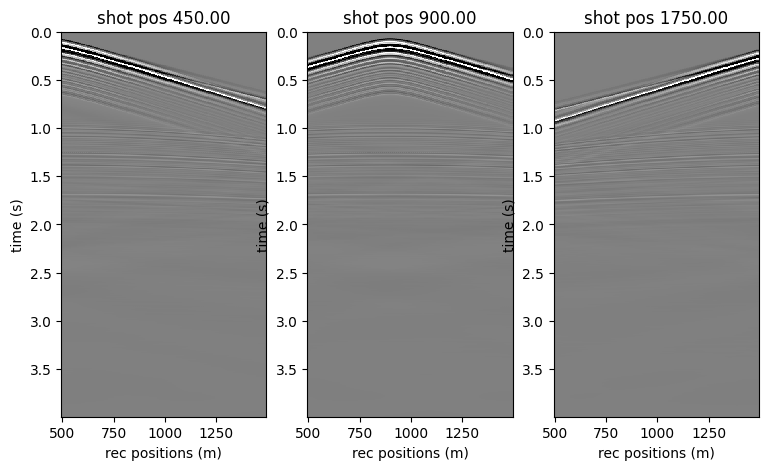

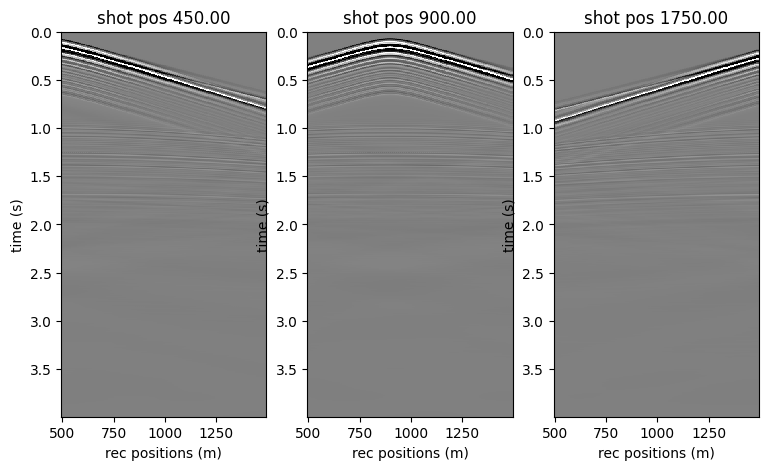

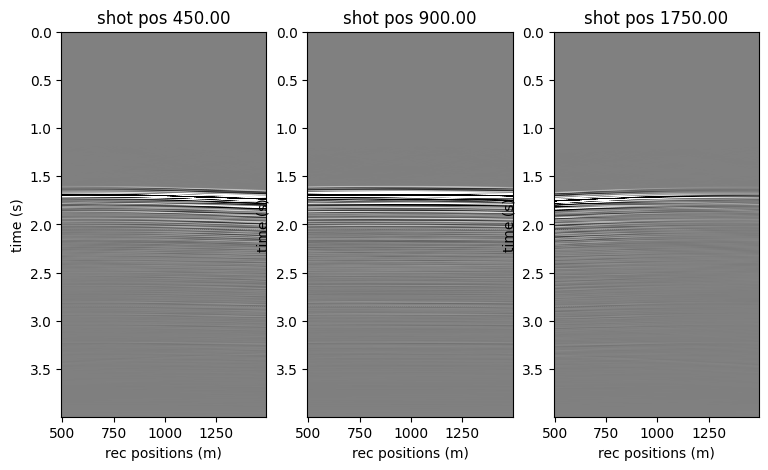

In [26]:
plotting.plot_data(np.squeeze(data_obs_base_p[:,:,:]),
                   dt,
                   n_shots=3,
                   src_locations=srcx,
                   rec_locations=recx,
                  )
plotting.plot_data(data_obs_moni_p[:],
                   dt,
                   n_shots=3,
                   src_locations=srcx,
                   rec_locations=recx)

plotting.plot_data(data_obs_moni_p[:] - data_obs_base_p[:],
                   dt,
                   n_shots=3,
                   src_locations=srcx,
                   rec_locations=recx)